# KDD Hands on tutorial, Barcelona 2024

# Part 2: distances measures and distance based classification and regression

Similarity-based approaches were one of the first proposals for tackling the
classification and regression of time series. Moveover, these types of technique are
also very common for performing other time series tasks such as clustering, or anomaly
detection, among others.

The first part of this notebook introduces the distances implemented in `aeon`,
starting with the simplest, the Euclidean distance. Then, it introduces the Dynamic
Time Warping (DTW) distance, its variants, such as Amerced DTW (ADTW), or the Shape
DTW (ShapeDTW), and some other alternative distances, such as the Move-Split-Merge (MSM).

The second part of this notebook, we demonstrate the use of these distances coupled with
the `KNearestNeighbors` classifier from `scikit-learn`, as well as a more appropriate
implementation of the `KNearestNeighbors` for time series, included in `aeon`. Similarly,
approaches for tackling TSER datasets using distance-based approaches are also presented.

The `aeon` documentation contains notebooks on [distances](https://www.aeon-toolkit.org/en/stable/examples/distances/distances.html) and [distance based
classification](https://www.aeon-toolkit.org/en/stable/examples/classification/distance_based.html)and using `aeon` distances
 with [sklearn](https://www.aeon-toolkit.org/en/stable/examples/distances/sklearn_distances.html)

In [28]:
# There are some deprecation warnings present in the notebook, we will ignore them.
# Remove this cell if you are interested in finding out what is changing soon, for
# aeon there will be big changes in out v1.0.0 release!
import warnings

warnings.filterwarnings("ignore")
from aeon.registry import all_estimators
all_estimators(
    "classifier", filter_tags={"algorithm_type": "distance"}, as_dataframe=True
)

,name,estimator
0,ElasticEnsemble,<class 'aeon.classification.distance_based._el...
1,KNeighborsTimeSeriesClassifier,<class 'aeon.classification.distance_based._ti...
2,ProximityTree,<class 'aeon.classification.distance_based._pr...


In [29]:
all_estimators(
    "regressor", filter_tags={"algorithm_type": "distance"}, as_dataframe=True
)

,name,estimator
0,KNeighborsTimeSeriesRegressor,<class 'aeon.regression.distance_based._time_s...


## Load example data
First of all, lets define two different random univariate time series (a and b) with
length $m=10$, and plot them.

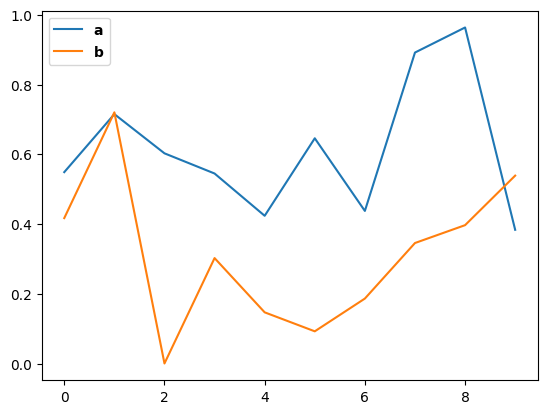

In [4]:
from aeon.testing.data_generation import make_example_1d_numpy
import seaborn as sns
import matplotlib.pyplot as plt

a = make_example_1d_numpy(n_timepoints=10, random_state=0)
b = make_example_1d_numpy(n_timepoints=10, random_state=1)

sns.lineplot(data=a, label=r"$\mathbf{a}$")
sns.lineplot(data=b, label=r"$\mathbf{b}$")

plt.show()

## Euclidean Distance (direct alignment)

The easiest way to compute the distance between both series may be to compute the direct
alignment, which sums differences between points at the same time steps. This distance
measure is known as Euclidean Distance

$$d_{ED}(a, b) = \sqrt{\sum_{i=1}^m(a_i-b_i)^2}$$

This distance can be computed as follows:

In [5]:
import numpy as np

ED = np.sqrt(np.sum(np.power(a-b,2)))

print(f"The Euclidean distance between a and b is {ED}")

The Euclidean distance between a and b is 1.236743116180222


`aeon` includes this distance measure (and a number of other more advanced distances)
in `aeon.distances`.

In [6]:
from aeon.distances import euclidean_distance

print(
    f"The Euclidean distance computed in aeon between a and b is",
    f"{euclidean_distance(a, b)}"
)

The Euclidean distance computed in aeon between a and b is 1.236743116180222


More visually, this distance is the squared root of the sum of each squared difference.
Obviously, a wider difference means a higher Euclidean distance.

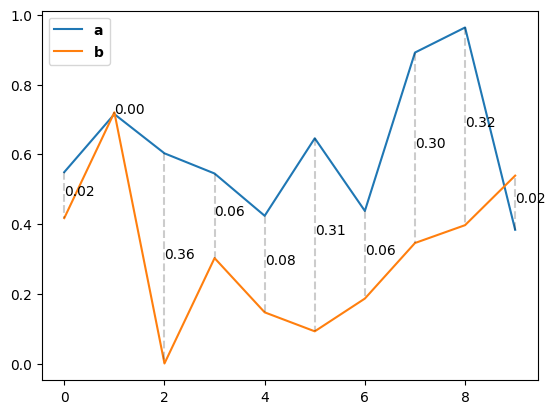

In [7]:
# Plot the time series distances pointwise following the path.
def plot_time_series_distances(a, b, cost_matrix, path):
    sns.lineplot(data=a, label=r"$\mathbf{a}$")
    sns.lineplot(data=b, label=r"$\mathbf{b}$")

    # join the points in the path
    for i in range(len(path)):
        plt.plot(
            [path[i][0], path[i][1]],
            [a[path[i][0]], b[path[i][1]]],
            'k--',
            alpha=0.2
        )
        plt.text(
            (path[i][0]+path[i][1])/2,
            (a[path[i][0]]+b[path[i][1]])/2,
            f"{cost_matrix[path[i][0], path[i][1]]:.2f}"
        )

    return plt

# Compute the squared distance matrix between a and b.
def squared_pointwise_distance(a, b):
    n_timesteps = len(a)
    distances_matrix = np.zeros((n_timesteps, n_timesteps))

    for i in range(n_timesteps):
        for j in range(n_timesteps):
            distances_matrix[i, j] = (a[i]-b[j])**2

    return distances_matrix


cost_matrix = squared_pointwise_distance(a,b)
path = [(i, i) for i in range(len(a))]

ax = plot_time_series_distances(a, b, cost_matrix, path)

plt.show()


Euclidean distance can be also identified as the squared root of sum of the squared
differences of the values in the diagonal of all possibles distances between elements in
both time series.

First of all, we compute the distance matrix, which has the distances for all the
elements in both time series:

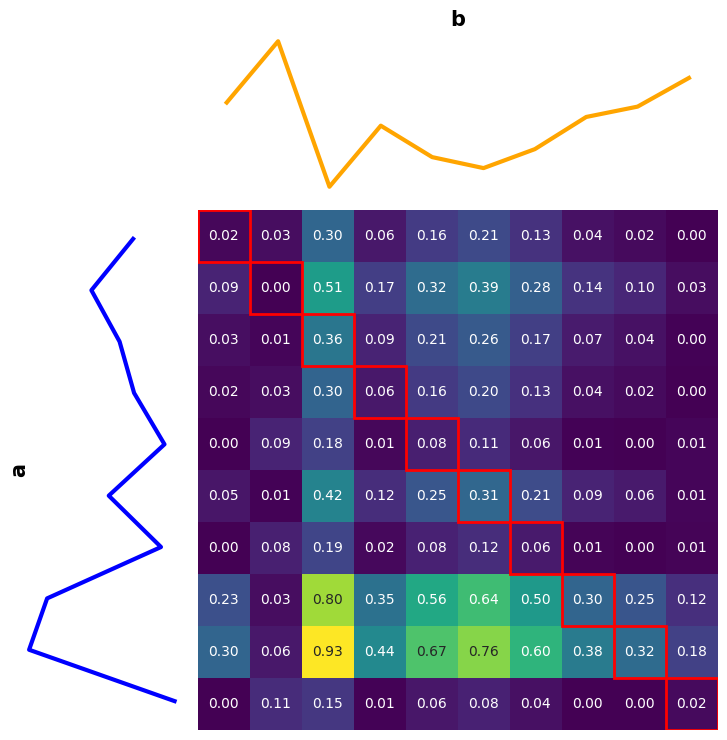

In [8]:
from aeon.distances import squared_distance

# This function draws a heatmap of the squared pointwise distances between a and b
def draw_distances_heatmap(distance_matrix, a, b, path):
    plt.figure(1, figsize=(8, 8))
    a_size = len(a)

    left, bottom = 0.01, 0.1
    w_ts = h_ts = 0.2
    left_h = left + w_ts + 0.02
    width = height = 0.65
    bottom_h = bottom + height + 0.02

    rect_s_y = [left, bottom, w_ts, height]
    rect_gram = [left_h, bottom, width, height]
    rect_s_x = [left_h, bottom_h, width, h_ts]

    ax_gram = plt.axes(rect_gram)

    # Plot the distance matrix with values.
    ax = sns.heatmap(
        distance_matrix,
        annot=True,
        fmt=".2f",
        cmap='viridis',
        ax=ax_gram,
        cbar=False,
        mask=np.isinf(distance_matrix)
    )

    for i in range(len(path)):
        ax.add_patch(
            plt.Rectangle(path[i][::-1], 1, 1, fill=False, edgecolor='red', lw=2)
        )

    ax_s_x = plt.axes(rect_s_x)
    ax_s_y = plt.axes(rect_s_y)

    ax_gram.axis("off")
    ax_gram.autoscale(False)

    # Plot the orange time series b.
    ax_s_x.plot(
        np.linspace(0.5, a_size-1.5, a_size), b, "-", linewidth=3.0, color="orange"
    )
    ax_s_x.set_xlim((0, a_size - 1))
    ax_s_x.set_title(r"$\mathbf{b}$", fontsize=15)
    ax_s_x.axis("off")

    # Plot the blue time series a.
    ax_s_y.plot(
        -a[::-1], np.linspace(0.5, a_size-1.5, a_size), "-", linewidth=3.0, color="blue"
    )
    ax_s_y.set_ylim((0, a_size - 1))
    ax_s_y.axis("off")
    ax_s_y.text(
        -1,
        int(a_size * 0.5) - 0.5,
        r"$\mathbf{a}$",
        fontsize=15,
        horizontalalignment="center",
        verticalalignment="center",
        rotation=90,
    )

    return ax

# Compute the squared pointwise distances between a and b
distance_matrix = squared_pointwise_distance(a, b)

# Draw the heatmap
ax = draw_distances_heatmap(distance_matrix, a, b, path)
plt.show()

## Elastic distances: Dynamic Time Warping (DTW) [1]

However, this is not the only way to compute distances between series. DTW allows
alignments across time steps, i.e. the time steps do not have to be aligned but the
first and last time steps.

In this first example, we allow the DTW to have sucessive alignments advance by at most
one time step along each series.

In [9]:
from aeon.distances import dtw_distance

print(
    f"The DTW distance computed in aeon between a and b is",
    f"{dtw_distance(a, b, window=0.1)}"
)

The DTW distance computed in aeon between a and b is 1.1985498275436108


Graphically, the DTW distance has been computed aligning these points:

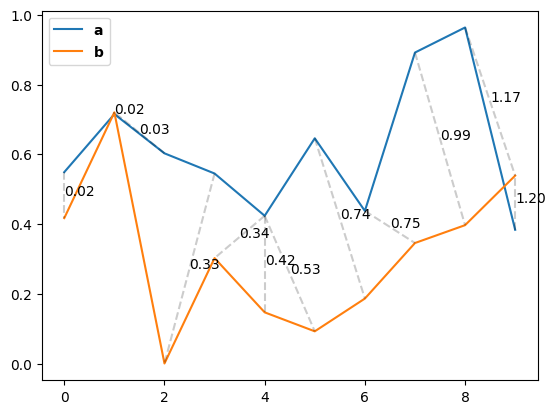

In [10]:
from aeon.distances import dtw_alignment_path, dtw_cost_matrix

path, _ = dtw_alignment_path(a, b, window=0.1)
cost_matrix = dtw_cost_matrix(a, b, window=0.1)

sns.lineplot(data=a, label=r"$\mathbf{a}$")
sns.lineplot(data=b, label=r"$\mathbf{b}$")

# join the points in the path
for i in range(len(path)):
    plt.plot([path[i][0], path[i][1]], [a[path[i][0]], b[path[i][1]]], 'k--', alpha=0.2)
    plt.text(
        (path[i][0]+path[i][1])/2,
        (a[path[i][0]]+b[path[i][1]])/2,
        f"{cost_matrix[path[i][0], path[i][1]]:.2f}"
    )

plt.show()

As can be observed, now, the distances are not computed for the same timepoints. They
are computed considering the collindant timepoints.

In this case, the distance is the minimum cost path that satisfies the aforementioned
constraints:

(Note that for readability of the path, the starting position should be the last one,
in this case the (9,9), and we move the closest timepoint. For example, from (9,9) we
can move to: A) (8, 9) with a cost of 1.32, B) (8, 8) with a cost of 1.32, or C) (9, 8)
with a cost of 1.17. The latter is the right choice.)

DTW distance between a and b is 1.1985498275436108.


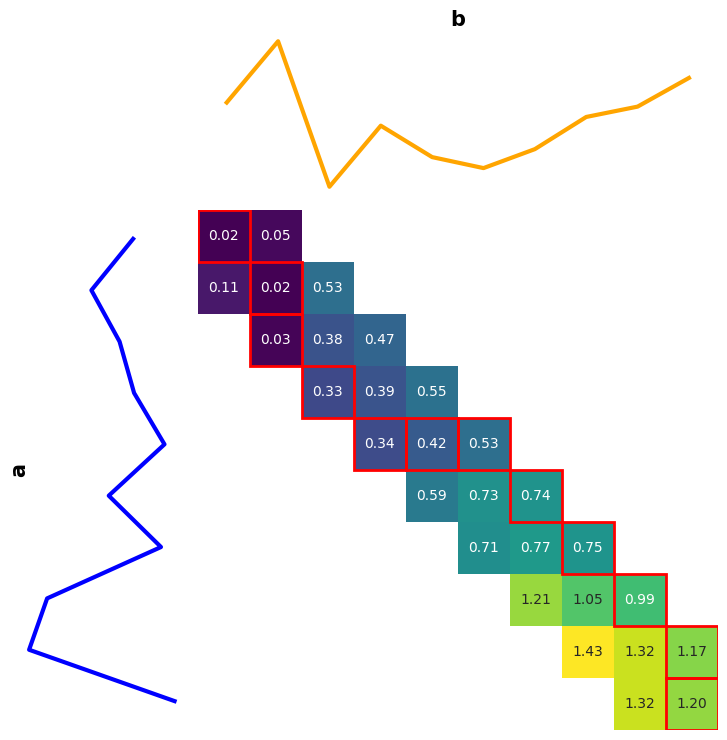

In [11]:
path, dtw_dist = dtw_alignment_path(a, b, window=0.1)
print(f"DTW distance between a and b is {dtw_dist}.")
# Compute the DTW cost matrix between a and b
cost_matrix = dtw_cost_matrix(a, b, window=0.1)

# Draw the heatmap
ax = draw_distances_heatmap(cost_matrix, a, b, path)
plt.show()

It is important to know that DTW warping can be more permisive, and allow a wider
alignment. To control this behaviour, we define another constraint: window size.

This windowing constraint avoids aligning points separated by more than a percentage of
the time series length. In other words, if the window constraint is $w$, the
alignment of the $i$-th point can only be performed with points in the interval
$[i - \lfloor w*m \rfloor, i +  \lfloor w*m \rfloor]$. In the previous scenario, no
window size was used (equivalent to have a window constraint of $w=1$.).

Now, if we reduce the window length to $w=0.5$, we can see that the path changes:

DTW distance with w=0.5 between a and b is 0.8566491595090396.


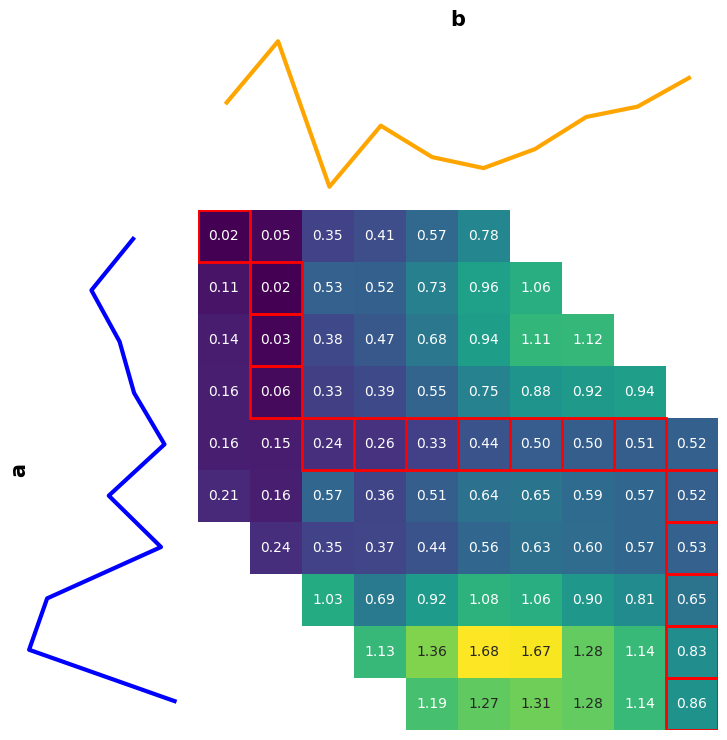

In [12]:
w = 0.5
path, dtw_dist = dtw_alignment_path(a, b, window=w)
print(f"DTW distance with {w=} between a and b is {dtw_dist}.")

# Compute the DTW cost matrix between a and b
cost_matrix = dtw_cost_matrix(a, b, window=w)

# Draw the heatmap
ax = draw_distances_heatmap(cost_matrix, a, b, path)
plt.show()

Now, as can be observed, the path satisfies the windowing constraint. Now, if we do not
desire to control the size, we use $w=1$ (which is the by-default value for $w$):

DTW distance with w=1 between a and b is 0.6574923997015053.


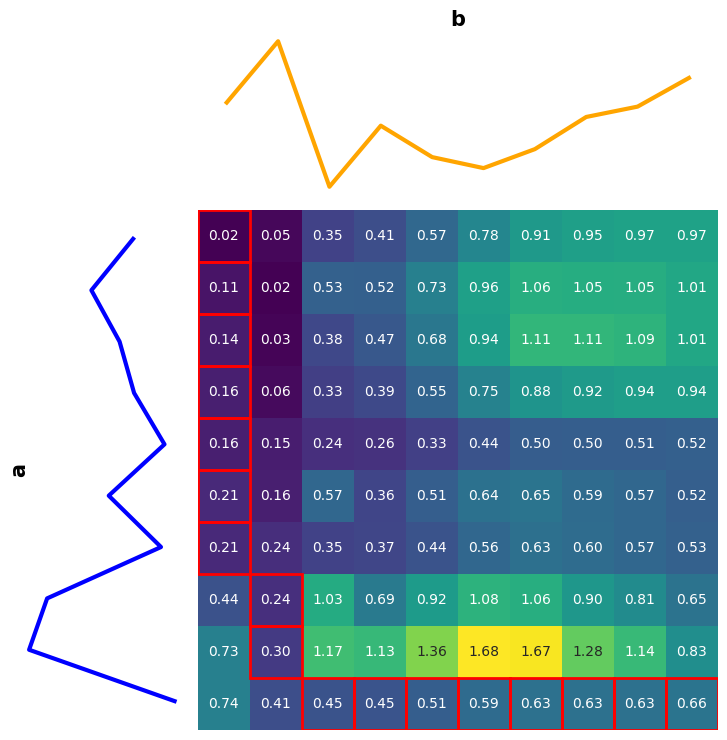

In [13]:
w = 1
path, dtw_dist = dtw_alignment_path(a, b, window=w)
print(f"DTW distance with {w=} between a and b is {dtw_dist}.")

# Compute the DTW cost matrix between a and b
cost_matrix = dtw_cost_matrix(a, b, window=w)

# Draw the heatmap
ax = draw_distances_heatmap(cost_matrix, a, b, path)
plt.show()

Finally, note that the most popular value for window is $w=0.2$:

DTW distance with w=0.2 between a and b is 0.9199809594402144.


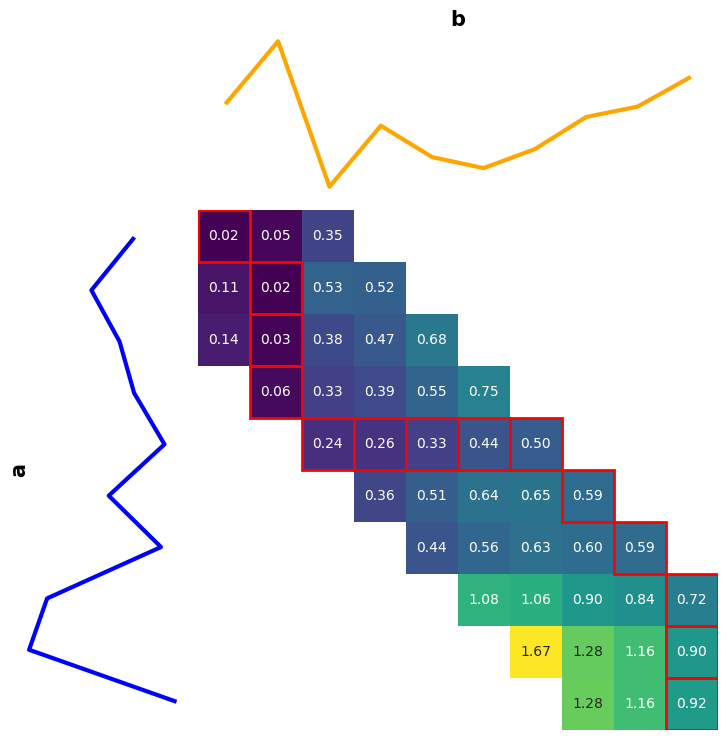

In [14]:
w = 0.2
path, dtw_dist = dtw_alignment_path(a, b, window=w)
print(f"DTW distance with {w=} between a and b is {dtw_dist}.")

# Compute the DTW cost matrix between a and b
cost_matrix = dtw_cost_matrix(a, b, window=w)

# Draw the heatmap
ax = draw_distances_heatmap(cost_matrix, a, b, path)
plt.show()

## Key distance measures: DTW variants

There are some other important DTW variants presented in the literature such as:
- Amerced Dynamic Time Warping (ADTW) [2], which imposes additive penalty for each warping action.
- Shape Dynamic Time Warping (ShapeDTW) [3], which scores each alignment of points using information including slope, wavelet transforms and piecewise approximations of the region around the points.
- Weighted Dynamic Time Warping (WDTW) [4], which imposes multiplicative penalty based on the distance from the diagonal.

All these DTW variants and others are implemented in `aeon`:

In [15]:
from aeon.distances._distance import DISTANCES

# These are the DTW variants available in aeon for time series:
dtw_variants = [d["name"] for d in DISTANCES if 'dtw' in d["name"]]
print(f"DTW variants available in aeon: {dtw_variants}")

DTW variants available in aeon: ['dtw', 'ddtw', 'wdtw', 'wddtw', 'adtw', 'shape_dtw']


They achieve a different distance value as can be observed:

In [16]:
from aeon.distances import get_distance_function

for variant in dtw_variants:
    distance_function = get_distance_function(variant)
    distance = distance_function(a, b, window=0.2)
    print(f"{variant} distance between a and b is {distance}")

dtw distance between a and b is 0.9199809594402144
ddtw distance between a and b is 0.31002884948727205
wdtw distance between a and b is 0.41867594005282865
wddtw distance between a and b is 0.13960840776560768
adtw distance between a and b is 1.5295335354191664
shape_dtw distance between a and b is 1.5295335354191666


## Key distance measures: DTW alternatives

Some other distance measures included in `aeon` are:

- Longest Common Subsequence (LCSS) [5]
- Manhattan
- Minkowski
- Move-Split-Merge (MSM) [6]
- Time Warp Edit (TWE) [7]

Now, we compute the distance between $a$ and $b$ using all possible distances in `aeon`:

In [17]:
for dist in DISTANCES:
    print(f"{dist['name']} distance between a and b is {dist['distance'](a, b)}")

euclidean distance between a and b is 1.236743116180222
squared distance between a and b is 1.5295335354191664
manhattan distance between a and b is 3.3323904398054873
minkowski distance between a and b is 1.2367431161802223
dtw distance between a and b is 0.6574923997015053
ddtw distance between a and b is 0.31002884948727205
wdtw distance between a and b is 0.3235461427240929
wddtw distance between a and b is 0.13960840776560768
lcss distance between a and b is 0.0
erp distance between a and b is 3.021868759085019
edr distance between a and b is 0.8
twe distance between a and b is 6.5094056644333955
msm distance between a and b is 3.3323904398054873
adtw distance between a and b is 1.5295335354191664
shape_dtw distance between a and b is 1.5295335354191666
sbd distance between a and b is 0.3633143104636234


# Distance-based univariate Time Series Classification (TSC) [8]

One of the first ways to classify a set of time series is by means of a k-nearest-
neighbours (kNN) approach coupled with an appropriate time series distance measure.

The easiest way is to use the `scikit-learn` kNN approach coupled with of the distances
implemented in `aeon`. There are two different ways:

1. Pass the distance function as a callable to the `metric` parameter in the constructor
or
2. Set the `metric` to "precomputed" in the constructor and pass a pairwise distance
matrix to `fit` and `predict`.

For this example, we load the gunpoint dataset using a 2D numpy array, which has two
dimensions (n_cases, n_timepoints), given that is the accepted format of `scikit-learn`.
Even though `aeon` allows the use of 2D numpy arrays, generally prefers 3D arrays in the
form (n_cases, n_channels, n_timepoints). For more information on data structures in
`aeon`, please see the [data_formats](../datasets/data_structures.ipynb) notebook.

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from aeon.datasets import load_from_tsfile

# Load the univariate TSC dataset as a 2D numpy array
X_train_utsc, y_train_utsc = load_from_tsfile(
    "./data/KDD_UTSC_TRAIN.ts",
    return_type="numpy2D"
)
X_test_utsc, y_test_utsc = load_from_tsfile(
    "./data/KDD_UTSC_TEST.ts",
    return_type="numpy2D"
)

print("Train shape:", X_train_utsc.shape)
print("Test shape:", X_test_utsc.shape)

Train shape: (40, 100)
Test shape: (40, 100)


In [19]:
knn = KNeighborsClassifier(n_neighbors=1, metric=dtw_distance)
knn.fit(X_train_utsc, y_train_utsc)
predictions_utsc = knn.predict(X_test_utsc)

accuracy = accuracy_score(y_test_utsc, predictions_utsc)
print(f"Accuracy of 1-NN (sklearn) with DTW is {accuracy}")

Accuracy of 1-NN (sklearn) with DTW is 0.55


`aeon` also includes a version of the kNN approach, specifically designed to deal with
time series. In this case, the input can be a 3D numpy array, which allows the usage
of this classifier with a multivariate time series, which we will see later.

In [20]:
from aeon.classification.distance_based import KNeighborsTimeSeriesClassifier

# Load the univariate TSC dataset as a 3D numpy array
X_train_utsc, y_train_utsc = load_from_tsfile("./data/KDD_UTSC_TRAIN.ts")
X_test_utsc, y_test_utsc = load_from_tsfile("./data/KDD_UTSC_TEST.ts")

print("Train shape:", X_train_utsc.shape)
print("Test shape:", X_test_utsc.shape)

Train shape: (40, 1, 100)
Test shape: (40, 1, 100)


In [21]:
knn_aeon = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance=dtw_distance)
knn_aeon.fit(X_train_utsc, y_train_utsc)
predictions_utsc_aeon = knn_aeon.predict(X_test_utsc)

accuracy = accuracy_score(y_test_utsc, predictions_utsc_aeon)
print(f"Accuracy of 1-NN (aeon) with DTW is {accuracy}")

Accuracy of 1-NN (aeon) with DTW is 0.55


Furthermore, there is one last way for coupling the `aeon` time series distances with the
standard kNN version included in the `scikit-learn` toolkit. This way consists in
precomputing the pairwise distances as follows:

In [22]:
from aeon.distances import dtw_pairwise_distance

train_dists = dtw_pairwise_distance(X_train_utsc)
test_dists = dtw_pairwise_distance(X_test_utsc, X_train_utsc)

# scikit-learn KNN classifier with precomputed distances
knn = KNeighborsClassifier(metric="precomputed", n_neighbors=1)
knn.fit(train_dists, y_train_utsc)
predictions_utsc = knn.predict(test_dists)

print(
    f"Accuracy of 1-NN (sklearn) with DTW using precomputed distances is",
    f"{accuracy_score(y_test_utsc, predictions_utsc)}"
)

Accuracy of 1-NN (sklearn) with DTW using precomputed distances is 0.55


As can be observed, all values are the same.

# Distance-based Multivariate TSC (MTSC) [9]

The `scikit-learn` kNN version can not be applied to 3D numpy arrays. However, as we
have just seen, there is a way in which `aeon` time series distances can be coupled with
`scikit-learn` kNN: the use of precomputed pairwise distances (in this case with the
ADTW distance, to show the variety of distances included in `aeon`):

In [23]:
from aeon.distances import adtw_pairwise_distance, adtw_distance
from aeon.datasets import load_basic_motions

# Load the multivariate dataset as a 3D numpy array
X_train_mtsc, y_train_mtsc = load_from_tsfile("./data/KDD_MTSC_TRAIN.ts")
X_test_mtsc, y_test_mtsc = load_from_tsfile("./data/KDD_MTSC_TEST.ts")

print("Train shape:", X_train_mtsc.shape)
print("Test shape:", X_test_mtsc.shape)

Train shape: (40, 4, 100)
Test shape: (40, 4, 100)


In [24]:
train_dists = adtw_pairwise_distance(X_train_mtsc)
test_dists = adtw_pairwise_distance(X_test_mtsc, X_train_mtsc)

# scikit-learn KNN classifier with precomputed distances
knn = KNeighborsClassifier(metric="precomputed", n_neighbors=1)
knn.fit(train_dists, y_train_mtsc)
predictions_mtsc = knn.predict(test_dists)

print(
    f"Accuracy of 1-NN (sklearn) with ADTW using precomputed distances is",
    f"{accuracy_score(y_test_mtsc, predictions_mtsc)}"
)

Accuracy of 1-NN (sklearn) with ADTW using precomputed distances is 0.525


Now, if we run the time series specific kNN approach included in `aeon` we do not need
to precompute the pairwise distance matrix, which sometimes may be computationally
and memory intensive:

In [25]:
knn_aeon = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance=adtw_distance)
knn_aeon.fit(X_train_mtsc, y_train_mtsc)
predictions_mtsc_aeon = knn_aeon.predict(X_test_mtsc)

accuracy = accuracy_score(y_test_mtsc, predictions_mtsc_aeon)
print(f"Accuracy of 1-NN (aeon) with ADTW is {accuracy}")

Accuracy of 1-NN (aeon) with ADTW is 0.525


For those distances already implemented in `aeon`, we can use their identifier instead
of using the callable distance. For example, the ADTW distance is identified as `"adtw"`:

In [26]:
knn_aeon = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="adtw")
knn_aeon.fit(X_train_mtsc, y_train_mtsc)
predictions_mtsc_aeon = knn_aeon.predict(X_test_mtsc)

accuracy = accuracy_score(y_test_mtsc, predictions_mtsc_aeon)
print(f"Accuracy of 1-NN (aeon) with ADTW is {accuracy}")

Accuracy of 1-NN (aeon) with ADTW is 0.525


# Distance-based Univariate Time Series Extrinsic Regression (UTSER) [10,11]

To avoid repeating content, in this section, we demonstrate the usefulness of the
`scikit-learn` kNN aproach coupled with an `aeon` distance for an UTSER
dataset using two of the most powerful distances: MSM and TWE.

In [27]:
from aeon.distances import (
    msm_distance,
    msm_pairwise_distance,
    twe_distance,
    twe_pairwise_distance,
)
from aeon.regression.distance_based import KNeighborsTimeSeriesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error


# Load the univariate TSER dataset as a 3D numpy array
X_train_utser, y_train_utser = load_from_tsfile("./data/KDD_UTSER_TRAIN.ts")
X_test_utser, y_test_utser = load_from_tsfile("./data/KDD_UTSER_TEST.ts")

print("Train shape:", X_train_utser.shape)
print("Test shape:", X_test_utser.shape)

Train shape: (72, 1, 100)
Test shape: (72, 1, 100)


In [26]:
train_dists = msm_pairwise_distance(X_train_utser)
test_dists = msm_pairwise_distance(X_test_utser, X_train_utser)
knn = KNeighborsRegressor(n_neighbors=1, metric="precomputed")
knn.fit(train_dists, y_train_utser)
predictions_utser = knn.predict(test_dists)

mse = mean_squared_error(y_test_utser, predictions_utser)
print(f"MSE of 1-NN (sklearn) with MSM is {mse}")

knn_aeon = KNeighborsTimeSeriesRegressor(n_neighbors=1, distance="msm")
knn_aeon.fit(X_train_utser, y_train_utser)
predictions_utser_aeon = knn_aeon.predict(X_test_utser)

mse = mean_squared_error(y_test_utser, predictions_utser_aeon)
print(f"MSE of 1-NN (aeon) with MSM is {mse}")

MSE of 1-NN (sklearn) with MSM is 1.3942060469112671
MSE of 1-NN (aeon) with MSM is 1.3942060469112671


In [27]:
# Now, for the TWE distance:
train_dists = twe_pairwise_distance(X_train_utser, window=0.1)
test_dists = twe_pairwise_distance(X_test_utser, X_train_utser, window=0.1)
knn = KNeighborsRegressor(n_neighbors=1, metric="precomputed")
knn.fit(train_dists, y_train_utser)
predictions_utser = knn.predict(test_dists)

mse = mean_squared_error(y_test_utser, predictions_utser)
print(f"MSE of 1-NN (sklearn) with TWE is {mse}")

knn_aeon = KNeighborsTimeSeriesRegressor(
    n_neighbors=1,
    distance="twe",
    distance_params={"window": 0.1}
)
knn_aeon.fit(X_train_utser, y_train_utser)
predictions_utser_aeon = knn_aeon.predict(X_test_utser)

mse = mean_squared_error(y_test_utser, predictions_utser_aeon)
print(f"MSE of 1-NN (aeon) with TWE is {mse}")

MSE of 1-NN (sklearn) with TWE is 1.7049822984745453
MSE of 1-NN (aeon) with TWE is 1.7049822984745453


As can be observed, both ways again achieve the same results for both distances.

# Distance-based Multivariate Time Series Extrinsic Regression (MTSER) [10,11]

To avoid repeating content, in this section, we demonstrate the usefulness of the
`scikit-learn` kNN aproach coupled with an `aeon` distance for an MTSER
dataset using other two powerful distances: ERP and WDTW.

In [28]:
from aeon.distances import (
    erp_distance,
    erp_pairwise_distance,
    wdtw_distance,
    wdtw_pairwise_distance,
)
from aeon.regression.distance_based import KNeighborsTimeSeriesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Load the multivariate TSER dataset as a 3D numpy array
X_train_mtser, y_train_mtser = load_from_tsfile("./data/KDD_MTSER_TRAIN.ts")
X_test_mtser, y_test_mtser = load_from_tsfile("./data/KDD_MTSER_TEST.ts")

print("Train shape:", X_train_mtser.shape)
print("Test shape:", X_test_mtser.shape)

Train shape: (72, 4, 100)
Test shape: (72, 4, 100)


In [29]:
train_dists = erp_pairwise_distance(X_train_mtser)
test_dists = erp_pairwise_distance(X_test_mtser, X_train_mtser)
knn = KNeighborsRegressor(n_neighbors=1, metric="precomputed")
knn.fit(train_dists, y_train_mtser)
predictions_mtser = knn.predict(test_dists)

mse = mean_squared_error(y_test_mtser, predictions_mtser)
print(f"MSE of 1-NN (sklearn) with ERP is {mse}")

knn_aeon = KNeighborsTimeSeriesRegressor(n_neighbors=1, distance="erp")
knn_aeon.fit(X_train_mtser, y_train_mtser)
predictions_mtser_aeon = knn_aeon.predict(X_test_mtser)

mse = mean_squared_error(y_test_mtser, predictions_mtser_aeon)
print(f"MSE of 1-NN (aeon) with ERP is {mse}")

MSE of 1-NN (sklearn) with ERP is 1.0155583588945694
MSE of 1-NN (aeon) with ERP is 1.0155583588945694


In [30]:
# Now, for the wdtw distance:
train_dists = wdtw_pairwise_distance(X_train_mtser, window=0.1)
test_dists = wdtw_pairwise_distance(X_test_mtser, X_train_mtser, window=0.1)
knn = KNeighborsRegressor(n_neighbors=1, metric="precomputed")
knn.fit(train_dists, y_train_mtser)
predictions_mtser = knn.predict(test_dists)

mse = mean_squared_error(y_test_mtser, predictions_mtser)
print(f"MSE of 1-NN (sklearn) with WDTW is {mse}")

knn_aeon = KNeighborsTimeSeriesRegressor(
    n_neighbors=1,
    distance="wdtw",
    distance_params={"window": 0.1}
)
knn_aeon.fit(X_train_mtser, y_train_mtser)
predictions_mtser_aeon = knn_aeon.predict(X_test_mtser)

mse = mean_squared_error(y_test_mtser, predictions_mtser_aeon)
print(f"MSE of 1-NN (aeon) with WDTW is {mse}")

MSE of 1-NN (sklearn) with WDTW is 1.3909486821400647
MSE of 1-NN (aeon) with WDTW is 1.3909486821400647


As can be observed, the results achieved for both ways, are the same. Note that
callable distances can also be coupled with the `KNeighborsTimeSeriesRegressor` in
`aeon` as follows:

In [31]:
# Now, using the WDTW distance as a callable function in aeon:
from aeon.distances import wdtw_distance

knn_aeon = KNeighborsTimeSeriesRegressor(
    n_neighbors=1,
    distance=wdtw_distance,
    distance_params={"window": 0.1}
)
knn_aeon.fit(X_train_mtser, y_train_mtser)
predictions_mtser_aeon = knn_aeon.predict(X_test_mtser)

mse = mean_squared_error(y_test_mtser, predictions_mtser_aeon)
print(f"MSE of 1-NN (aeon) with WDTW as callable function is {mse}")

MSE of 1-NN (aeon) with WDTW as callable function is 1.3909486821400647


# References

[1] Keogh, E., & Ratanamahatana, C. A. Exact indexing of dynamic time warping. Knowledge and information systems, 7, 358-386, 2005.

[2] Herrmann, M., & Webb, G. I. Amercing: an intuitive and effective constraint for dynamic time warping. Pattern Recognition, 137, 109333, 2023.

[3] Zhao, J., & Itti, L. shapeDTW: Shape dynamic time warping. Pattern Recognition, 74, 171-184, 2018.

[4] Jeong, Y. S., Jeong, M. K., & Omitaomu, O. A. Weighted dynamic time warping for time series classification. Pattern recognition, 44(9), 2231-2240, 2011.

[5] Vlachos, M., Kollios, G., & Gunopulos, D. Discovering similar multidimensional trajectories. In Proceedings 18th international conference on data engineering (pp. 673-684). IEEE, 2002.

[6] Stefan, A., Athitsos, V., & Das, G. The move-split-merge metric for time series. IEEE transactions on Knowledge and Data Engineering, 25(6), 1425-1438, 2012.

[7] Marteau, P. F. Time warp edit distance with stiffness adjustment for time series matching. IEEE transactions on pattern analysis and machine intelligence, 31(2), 306-318, 2008.

[8] Middlehurst, M., Schäfer, P., & Bagnall, A. Bake off redux: a review and experimental evaluation of recent time series classification algorithms. Data Mining and Knowledge Discovery, 1-74, 2024.

[9] Shifaz, A., Pelletier, C., Petitjean, F., & Webb, G. I. Elastic similarity and distance measures for multivariate time series. Knowledge and Information Systems, 65(6), 2665-2698, 2023.

[10] Tan, C. W., Bergmeir, C., Petitjean, F., & Webb, G. I. Time series extrinsic regression: Predicting numeric values from time series data. Data Mining and Knowledge Discovery, 35(3), 1032-1060, 2021.

[11] Guijo-Rubio, D., Middlehurst, M., Arcencio, G., Silva, D. F., & Bagnall, A. Unsupervised feature based algorithms for time series extrinsic regression. Data Mining and Knowledge Discovery, 1-45, 2024.